<h1>Quantum Teleportation Example</h1>

<p1>
In this notebook, we will expand on the ability to create circuits by incorporating classical bits or communication channels in our circuit.

</p1>

<p1>
Quantum teleportation allows us to transfer information, a quantum state, from one qubit to another that is possibly in a different location. This is accomplished using the properties of entanglement. This does not violate the no-cloning theorem do to the measurements involved in the algorithm destroying information, or the state, in the initial qubit and using the information gained from the measurement to create an exact copy in the secondary qubit.
</p1>

<p1>We will describe the algorithm in detail using Alice and Bob. We will assume Alice has a 3rd qubit, *q*, whose state she wants to transmit via quantum teleportation to Bob. Furthermore, Alice and Bob's qubits, *a* and *b* respectively, start in the 0-state.</p1>


<p1>Here are the algorithm steps:<ol><li>First Alice and Bob entangle their qubits using a Hadamard gate on *a* and CX-gate with *a* as the control and *b* as the target. This results in a Bell state of |00>+|11>, neglecting the normalization constant.</li>
    <li>Next, Alice applies a CX-gate from *q* to *a*, then a Hadamard gate to *q*.</li>
    <li>Now Alice measures *q* and *a* and sends a classical bit corresponding to each measurements state to Bob via a classical channel: 1 if |1> is measured and 0 if |0> is measured.</li>
    <li>Bob receives the bits and first applies an X-gate to *b* if the bit corresponding to *a* is 1 and then a Z-gate to *b* if the bit corresponding to *q* is 1.</li>
    <li>Qubit *b* is now exactly in the same state as qubit *q* started in.</li></ol></p1>

<p1>There are other versions the of quantum teleportation algorithm that conditions the operations on *b* by the state of *a* and *q* without classical bits and one that uses a single classical bit. The outcome of these methods are the same, but using classical bits allows *a* and *b* to not be in the same location and the two classical bit example is easier to follow.</p1>

<p1>Now, lets build the circuit in Qiskit, simulate it, and then run it on a QPU!</p1>

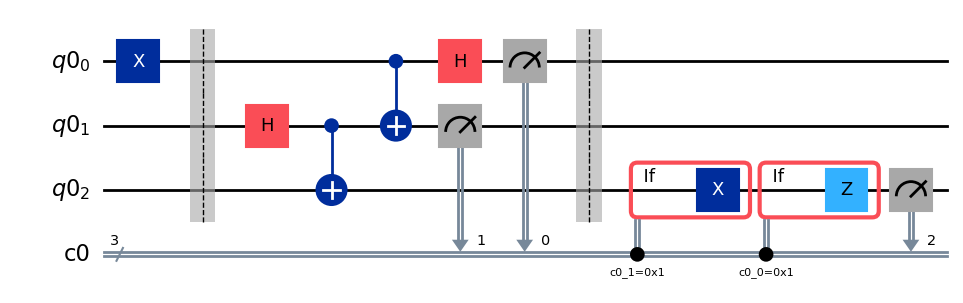

In [ ]:
# First we create the 3 qubit circuit with 3 classical bits and perform the operations above
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister

# First we create our qubit and classical bit (clbit) registers
qubits = QuantumRegister(3)
clbits = ClassicalRegister(3)

qc = QuantumCircuit(qubits, clbits)

# Qubits:
# q = q0 = State |q> that we want to teleport
# a = q1 = Alice's half of the Bell pair
# b = q2 = Bob's half of the Bell pair, the destination of the teleportation
(q0, q1, q2) = qubits

# Classical Bits:
# c0 = the clbit corresponding to the measurement of q0
# c1 = the clbit corresponding to the measurement of q1
# c2 = the clbit corresponding to the measurement of q2
(c0, c1, c2) = clbits

# Note: all qubits start in the |0> state in Qiskit
# So we can set this qubit to whatever we want in this step. Let's use 1 arbitrarily
qc.x(q0)

# Now we will insert a visual barrier to separate this from the rest of the circuit
qc.barrier()

# Step 1
qc.h(q1)
qc.cx(q1,q2)

# Step 2
qc.cx(q0,q1)
qc.h(q0)

# Step 3
# Here, we pass the list of qubits we wish to measure, and then, the list of classical bits
# we want the measurements to be stored in. If i is the list index, the ith qubit in the
# first list is measured and the result is stored in the ith classical bit in the second
# list
qc.measure([q0,q1],[c0,c1])

# We will place a second visual barrier here to indicate the physical separation of the qubits
qc.barrier()

# Step 4
# Here the with statement is used like an if statement.
# In other words, the code within the if block executes if the with statement is true.
# The with block is useful because it properly acquires and releases resources with the condition.
with qc.if_test((c1, 1)):
    qc.x(q2)

with qc.if_test((c0, 1)):
    qc.z(q2)

# Step 5
qc.measure(q2,c2)


# Now lets draw this circuit to see if it looks like what we expect
qc.draw('mpl')

<p1>The <code>measure</code> gate allows us to measure a qubit and store the result in a classical bit. For more information on <code>measure</code> refer to the following <a href=https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#measure>IBM documentation</a></p1>

<p1>Now we will run a simulation of this using <code>AerSimulator</code>. You will need to install <code>qiskit_aer</code> using <code>pip install qiskit_aer</code> or your installation manager specific method. If you installed the packages with the requirements file, then this is already installed. This allows us to run our code in a simulation with a general noise model, a specified noise model, or no noise model, read more <a href=https://docs.quantum.ibm.com/guides/local-testing-mode#aersimulator-examples>here</a>. First, we will run the simulation with no noise, then with noise. This will allow us to verify the circuit works as expected and observe the effects noise can have on the circuit. We will also visualize the outcome probabilities of the circuit using <code>plot_histogram()</code> from <code>qiskit.visualization</code>. This could be done using Matplotlib as well.</p1>

<p1>The use of <code>Sampler</code> with measure can be confusing. However, you can reference the PUBResult <a href=https://docs.quantum.ibm.com/guides/primitive-input-output#overview-of-primitive-results>here</a> and note our classical register is called *c0* from the visualization above. Qiskit's method of accessing the results here can be finicky due the nature of its design within Python. So, if you are having trouble accessing results it is probably a good start to double check the registers in your circuit and how you are trying to access them in the PUBResult.</p1>

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
from qiskit_aer import AerSimulator

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='<API TOKEN>'
)


#_______________________________________________________________________________
# Example without Noise
#_______________________________________________________________________________

# Passing nothing into AerSimulator() produces a backend model with no noise.
aer_nl = AerSimulator()

# Transpiling for backend 
pm_nl = generate_preset_pass_manager(backend=aer_nl, optimization_level=1)
isa_qc_nl = pm_nl.run(qc)


sampler    = Sampler(mode=aer_nl)
result_nl  = sampler.run([isa_qc_nl]).result()

#_______________________________________________________________________________
# Example with Noise
#_______________________________________________________________________________

# By passing in "ibm_brisbane" we get the details to the QPU
# and then use AERSimulator.from_backend() to simulate the noise that IBM brisbane has.
n_backend = service.backend("ibm_brisbane")
aer_n = AerSimulator.from_backend(n_backend)

# Transpiling for backend 
pm_n = generate_preset_pass_manager(backend=aer_n, optimization_level=1)
isa_qc_n = pm_n.run(qc)

sampler = Sampler(mode=aer_n)
result_n  = sampler.run([(isa_qc_n )]).result()

<p1>First we will plot the noiseless results and then the results once noise is considered.</p1>

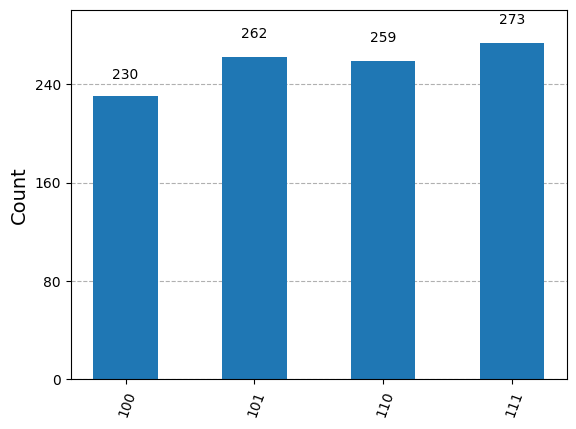

In [3]:
from qiskit.visualization import plot_histogram

plot_histogram(result_nl[0].data.c0.get_counts())


<p1>Note the qubits in the plot above, from bottom to top, are *q2*, *q1*, *q0*. We see in the ideal case, with no noise present, *q2* is always measured to be |1> as expected since *q0* is set to be |1> in the beginning of the circuit.</p1>

<p1>Now, lets plot the other sample and see how the noise affects the circuit!</p1>

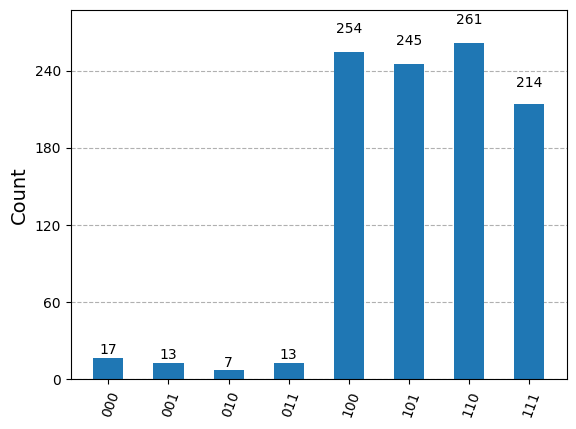

In [4]:
plot_histogram(result_n[0].data.c0.get_counts())

<p1>Now we can see that in about 7.1% of the shots *q2* is measured to be 0! This disagrees with the initial state of *q*. That means the rest of the time, about 92.9%, the teleportation works as intended. This error rate can be directly attributed to the noise in the QPU since we do not see these errors in the noiseless simulation. The percentages will vary by several percent from run to run.</p1>

<p1>Now we can run our code on a real QPU and compare to the simulation results.</p1>

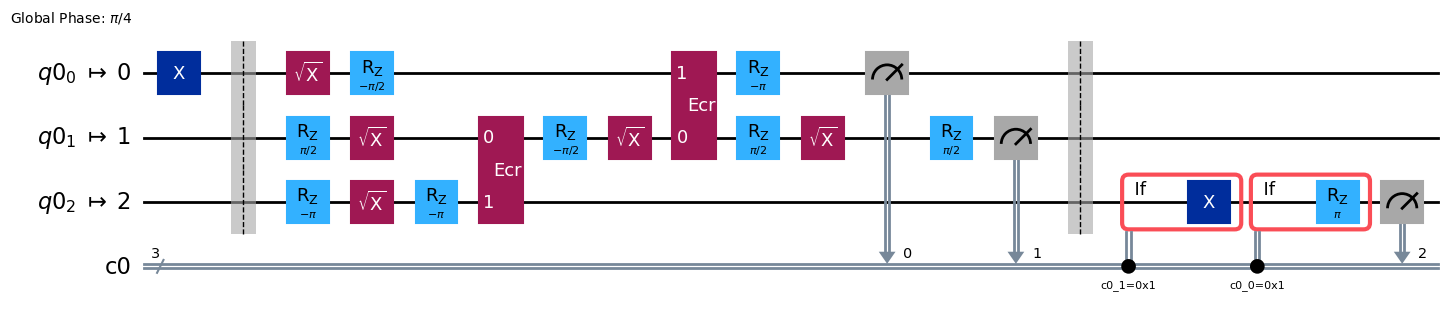

In [ ]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='<API TOKEN>'
)


backend = service.least_busy(simulator=False, operational=True)


pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(qc)
 
isa_qc.draw('mpl', idle_wires=False)  

In [ ]:
sampler = Sampler(mode=backend)

#Note: Sampler does not support resilience levels
#Note: Twirling or dynamical_decouplng could be used, follow the link below for more information
job = sampler.run([isa_qc],shots=5000)
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cwp3wnaehebg008hp26g


<p1> The <code>Sampler</code> does not support the same types of error mitigation as the <code>Estimator</code> does. If you would like to know more about error mitigation while using <code>Sampler</code> see <a href=https://docs.quantum.ibm.com/guides/configure-error-mitigation>Configure Error Mitigation</a> on IBM's website.</p1>

<p1>Once the job has completed run the cell below. You can check the status of a <code>job</code> using <code>job.status()</code> or check your <a href=https://quantum.ibm.com/>account dashboard</a>.</p1>

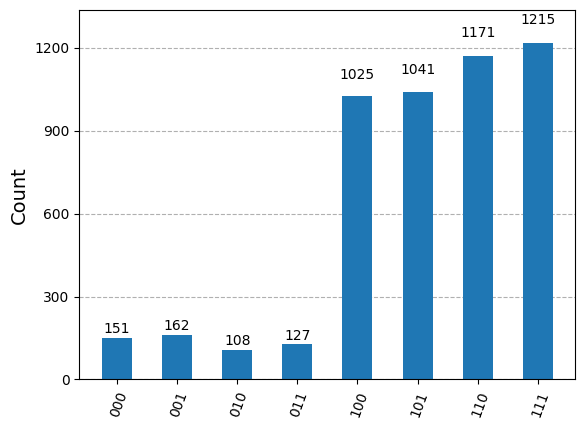

In [12]:
plot_histogram(job.result()[0].data.c0.get_counts())

<p1> We can see very similar results to the simulation with error, about a 10.9% error rate! You have now done quantum teleportation using a classical channel to teleport a quantum state! Furthermore, you have seen how noise can affect a quantum circuit and how similar Qiskit simulations can be to running your code on an actual QPU!</p1>